In [15]:
# Core libraries and model APIs
from pathlib import Path
import warnings

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import time

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import balanced_accuracy_score, f1_score, classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight, compute_sample_weight

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

sns.set_theme(style="whitegrid", palette="deep")
pd.options.display.float_format = '{:,.2f}'.format

In [3]:
# Load and tidy the engineered feature sheet
ctg_path = Path("cardiotocography/CTG.xls")
assert ctg_path.exists(), f"Expected Excel file at {ctg_path.resolve()}"

def read_feature_sheet(path: Path, sheet=0):
    """Load the CTG feature sheet, using row 2 as headers and data from row 3 onward."""
    xls = pd.ExcelFile(path)
    sheet_name = xls.sheet_names[sheet] if isinstance(sheet, int) else sheet
    try:
        df = pd.read_excel(xls, sheet_name=sheet_name, header=1)
    except ValueError:
        df = pd.read_excel(xls, sheet_name=sheet_name, header=0)
    return df

raw_features = read_feature_sheet(ctg_path, sheet=1)
raw_features.shape

(2129, 46)

In [4]:
# Clean columns, drop leakage, and ensure numerics
def tidy_sheet(df: pd.DataFrame) -> pd.DataFrame:
    cleaned = df.copy()
    cleaned.columns = [str(col).strip() for col in cleaned.columns]
    cleaned = cleaned.dropna(axis=0, how='all').dropna(axis=1, how='all')
    cleaned = cleaned.loc[:, ~cleaned.columns.str.contains('^Unnamed', case=False)]
    cleaned = cleaned.loc[:, ~cleaned.columns.duplicated()]
    rename_map = {
        'MSTV': 'mSTV',
        'MLTV': 'mLTV',
        'Variance ': 'Variance',
        'TENDENCY': 'Tendency'
    }
    cleaned = cleaned.rename(columns={k: v for k, v in rename_map.items() if k in cleaned.columns})
    return cleaned

sheet2 = tidy_sheet(raw_features)
target_col = 'NSP'
label_leak_cols = ['CLASS', 'A', 'B', 'C', 'D', 'E', 'AD', 'DE', 'LD', 'FS', 'SUSP']
feature_cols = [col for col in sheet2.columns if col not in label_leak_cols + [target_col]]
clean_df = (
    sheet2
    .drop(columns=label_leak_cols, errors='ignore')
    .dropna(axis=0, how='all')
    .drop_duplicates()
)

# Coerce numeric columns and drop rows without labels
numeric_cols = feature_cols
clean_df[numeric_cols] = clean_df[numeric_cols].apply(pd.to_numeric, errors='coerce')
clean_df = clean_df.dropna(subset=[target_col]).copy()
clean_df[target_col] = clean_df[target_col].astype(int)

X = clean_df[numeric_cols]
y = clean_df[target_col]
X.shape, y.value_counts().sort_index()

((2115, 30),
 NSP
 1    1647
 2     293
 3     175
 Name: count, dtype: int64)

In [5]:
X.head()

,b,e,AC,FM,UC,DL,DS,DP,DR,LB,...,Width,Min,Max,Nmax,Nzeros,Mode,Mean,Median,Variance,Tendency
0,240.00,357.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,120.00,...,64.00,62.00,126.00,2.00,0.00,120.00,137.00,121.00,73.00,1.00
1,5.00,632.00,4.00,0.00,4.00,2.00,0.00,0.00,0.00,132.00,...,130.00,68.00,198.00,6.00,1.00,141.00,136.00,140.00,12.00,0.00
2,177.00,779.00,2.00,0.00,5.00,2.00,0.00,0.00,0.00,133.00,...,130.00,68.00,198.00,5.00,1.00,141.00,135.00,138.00,13.00,0.00
3,411.00,"1,192.00",2.00,0.00,6.00,2.00,0.00,0.00,0.00,134.00,...,117.00,53.00,170.00,11.00,0.00,137.00,134.00,137.00,13.00,1.00
4,533.00,"1,147.00",4.00,0.00,5.00,0.00,0.00,0.00,0.00,132.00,...,117.00,53.00,170.00,9.00,0.00,137.00,136.00,138.00,11.00,1.00


In [6]:
# Stratified train/test split and class weights
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)
classes = np.unique(y_train)
class_weight_values = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weight_dict = dict(zip(classes, class_weight_values))
sample_weight_train = compute_sample_weight(class_weight='balanced', y=y_train)

distribution = (
    pd.DataFrame({
        'Split': ['Train', 'Test'],
        'Size': [len(y_train), len(y_test)],
        'Normal (1)': [np.mean(y_train == 1), np.mean(y_test == 1)],
        'Suspect (2)': [np.mean(y_train == 2), np.mean(y_test == 2)],
        'Pathologic (3)': [np.mean(y_train == 3), np.mean(y_test == 3)]
    })
    .rename(columns=lambda c: c if c in {'Split', 'Size'} else f'{c} proportion')
)
distribution, class_weight_dict

(   Split  Size  Normal (1) proportion  Suspect (2) proportion  \
 0  Train  1480                   0.78                    0.14   
 1   Test   635                   0.78                    0.14   
 
    Pathologic (3) proportion  
 0                       0.08  
 1                       0.08  ,
 {np.int64(1): np.float64(0.4278693263949118),
  np.int64(2): np.float64(2.4065040650406506),
  np.int64(3): np.float64(4.043715846994536)})

In [22]:
# Shared evaluation helper edited with latency
results = []

def evaluate_model(name, estimator, X_train, y_train, X_test, y_test, fit_kwargs=None, display_report=False):
    fit_kwargs = fit_kwargs or {}
    fit_start = time.time()
    estimator.fit(X_train, y_train, **fit_kwargs)
    fit_time = time.time() - fit_start
    pred_start = time.time()
    y_pred = estimator.predict(X_test)
    pred_time = time.time() - pred_start
    bal_acc = balanced_accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='macro')
    results.append({'Model': name, 'Balanced Accuracy': bal_acc, 'F1 Macro': f1, 'Prediction Time': pred_time, 'Fit Time': fit_time})
    print(f"{name} — Balanced Accuracy: {bal_acc:.3f}, Macro F1: {f1:.3f}, Prediction Time: {pred_time:.4f}s, Fit Time: {fit_time:.4f}s")
    if display_report:
        print(classification_report(y_test, y_pred, digits=3))
    disp = ConfusionMatrixDisplay.from_predictions(
        y_test, y_pred, display_labels=sorted(classes), normalize='true', cmap='Blues'
    )
    disp.ax_.set_title(f"{name} — Normalized Confusion Matrix")
    plt.show()
    return estimator, y_pred

classes

array([1, 2, 3])

Model 1: Logistic Regression

Logistic Regression — Balanced Accuracy: 0.831, Macro F1: 0.786, Prediction Time: 0.0011s, Fit Time: 0.0364s
              precision    recall  f1-score   support

           1      0.980     0.889     0.932       494
           2      0.549     0.830     0.661        88
           3      0.759     0.774     0.766        53

    accuracy                          0.871       635
   macro avg      0.763     0.831     0.786       635
weighted avg      0.902     0.871     0.881       635



c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


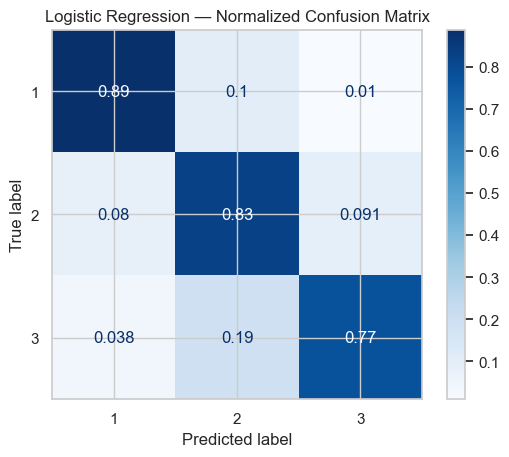

In [24]:
log_reg_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('log_reg', LogisticRegression(
        max_iter=1000,
        multi_class='multinomial',
        class_weight='balanced',
        solver='lbfgs'
    ))
])
_ = evaluate_model('Logistic Regression', log_reg_pipeline, X_train, y_train, X_test, y_test, display_report=True)

Model 2: Decision Tree

Decision Tree — Balanced Accuracy: 0.872, Macro F1: 0.839, Prediction Time: 0.0020s, Fit Time: 0.0162s
              precision    recall  f1-score   support

           1      0.965     0.903     0.933       494
           2      0.597     0.807     0.686        88
           3      0.889     0.906     0.897        53

    accuracy                          0.890       635
   macro avg      0.817     0.872     0.839       635
weighted avg      0.908     0.890     0.896       635



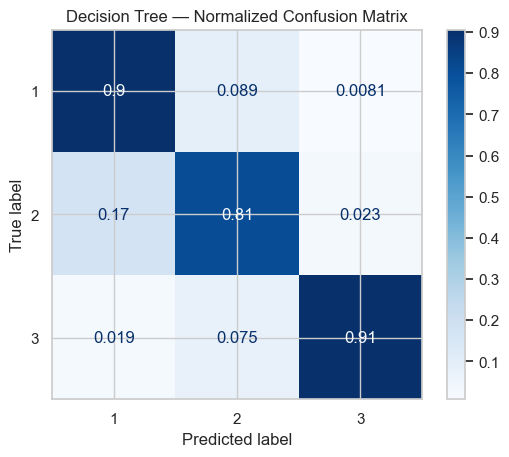

In [26]:
tree_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('tree', DecisionTreeClassifier(
        criterion='gini',
        min_samples_leaf=5,
        max_depth=None,
        class_weight='balanced',
        random_state=42
    ))
])
_ = evaluate_model('Decision Tree', tree_pipeline, X_train, y_train, X_test, y_test, display_report=True)

Model 3: Random Forest

Random Forest — Balanced Accuracy: 0.915, Macro F1: 0.911, Prediction Time: 0.0609s, Fit Time: 0.3770s
              precision    recall  f1-score   support

           1      0.975     0.964     0.969       494
           2      0.794     0.875     0.832        88
           3      0.960     0.906     0.932        53

    accuracy                          0.946       635
   macro avg      0.910     0.915     0.911       635
weighted avg      0.949     0.946     0.947       635



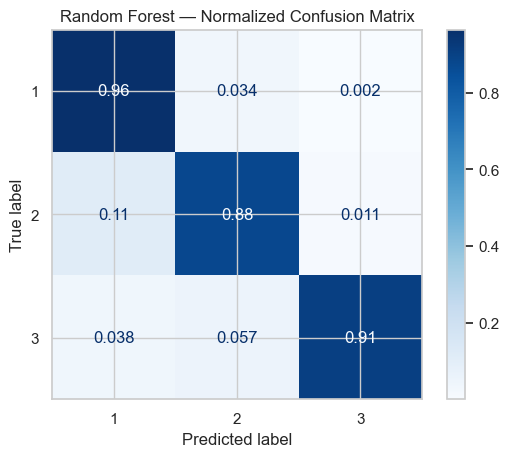

In [27]:
rf_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('rf', RandomForestClassifier(
        n_estimators=300,
        max_depth=None,
        min_samples_leaf=4,
        class_weight='balanced',
        random_state=42,
        n_jobs=-1
    ))
])
_ = evaluate_model('Random Forest', rf_pipeline, X_train, y_train, X_test, y_test, display_report=True)

Model 4: Gradient Boosting

Gradient Boosting — Balanced Accuracy: 0.911, Macro F1: 0.921, Prediction Time: 0.0083s, Fit Time: 4.4652s
              precision    recall  f1-score   support

           1      0.968     0.978     0.973       494
           2      0.849     0.830     0.839        88
           3      0.980     0.925     0.951        53

    accuracy                          0.953       635
   macro avg      0.932     0.911     0.921       635
weighted avg      0.952     0.953     0.952       635



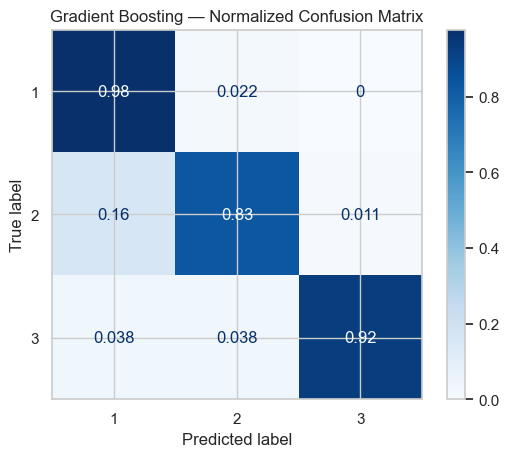

In [28]:
gb_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('gb', GradientBoostingClassifier(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=3,
        random_state=42
    ))
])
gb_fit_kwargs = {'gb__sample_weight': sample_weight_train}
_ = evaluate_model('Gradient Boosting', gb_pipeline, X_train, y_train, X_test, y_test, fit_kwargs=gb_fit_kwargs, display_report=True)

Model 5: Support Vector Machine (SVM)

Support Vector Machine — Balanced Accuracy: 0.857, Macro F1: 0.825, Prediction Time: 0.0259s, Fit Time: 0.0393s
              precision    recall  f1-score   support

           1      0.976     0.903     0.938       494
           2      0.592     0.875     0.706        88
           3      0.875     0.792     0.832        53

    accuracy                          0.890       635
   macro avg      0.814     0.857     0.825       635
weighted avg      0.914     0.890     0.897       635



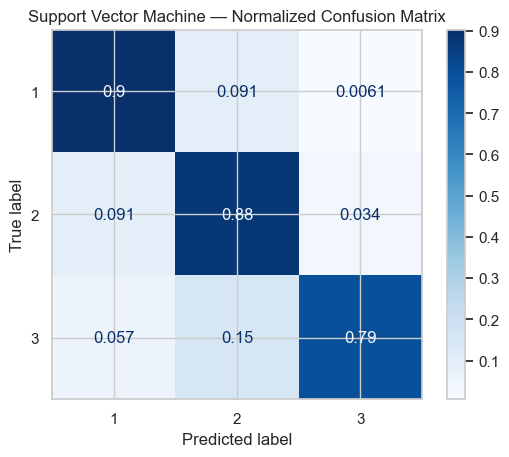

In [29]:
svm_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('svm', SVC(
        kernel='rbf',
        C=2.0,
        gamma='scale',
        class_weight='balanced'
    ))
])
_ = evaluate_model('Support Vector Machine', svm_pipeline, X_train, y_train, X_test, y_test, display_report=True)

Model 6: Neural Network (MLP)

Neural Network (MLP) — Balanced Accuracy: 0.801, Macro F1: 0.832, Prediction Time: 0.0020s, Fit Time: 0.1873s
              precision    recall  f1-score   support

           1      0.941     0.974     0.957       494
           2      0.744     0.693     0.718        88
           3      0.929     0.736     0.821        53

    accuracy                          0.915       635
   macro avg      0.871     0.801     0.832       635
weighted avg      0.913     0.915     0.913       635



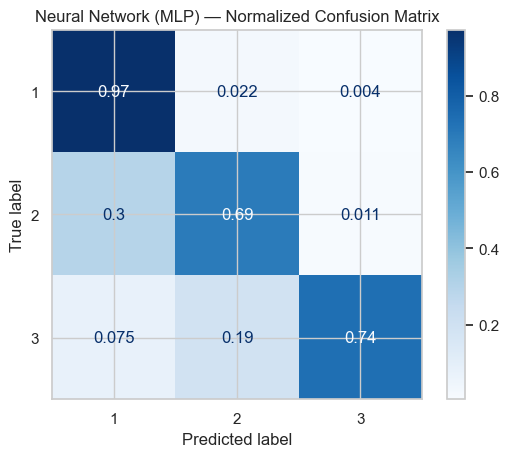

In [30]:
mlp_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('mlp', MLPClassifier(
        hidden_layer_sizes=(64, 32),
        activation='relu',
        alpha=1e-3,
        learning_rate='adaptive',
        max_iter=1000,
        early_stopping=True,
        random_state=42
    ))
])
_ = evaluate_model('Neural Network (MLP)', mlp_pipeline, X_train, y_train, X_test, y_test, display_report=True)

Model 7: k-Nearest Neighbors (kNN)

k-Nearest Neighbors — Balanced Accuracy: 0.722, Macro F1: 0.771, Prediction Time: 1.7469s, Fit Time: 0.0063s
              precision    recall  f1-score   support

           1      0.916     0.968     0.941       494
           2      0.659     0.614     0.635        88
           3      1.000     0.585     0.738        53

    accuracy                          0.887       635
   macro avg      0.858     0.722     0.771       635
weighted avg      0.887     0.887     0.882       635



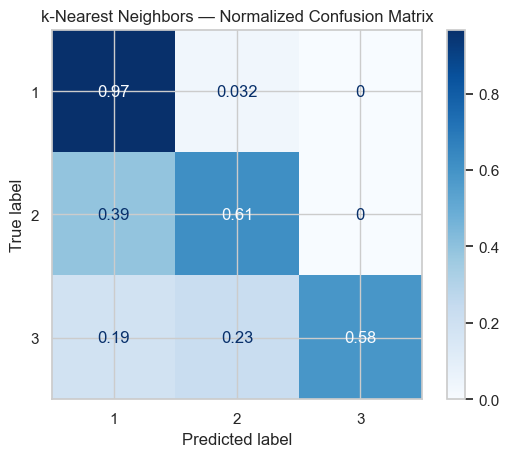

In [31]:
knn_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier(n_neighbors=15))
])
_ = evaluate_model('k-Nearest Neighbors', knn_pipeline, X_train, y_train, X_test, y_test, display_report=True)

In [32]:
# Aggregate model performance
results_df = pd.DataFrame(results).sort_values('Balanced Accuracy', ascending=False)
results_df.reset_index(drop=True)

,Model,Balanced Accuracy,F1 Macro,Prediction Time,Fit Time
0,Random Forest,0.91,0.91,0.06,0.38
1,Gradient Boosting,0.91,0.92,0.01,4.47
2,Decision Tree,0.87,0.84,0.00,0.02
3,Decision Tree,0.87,0.84,0.00,0.02
4,Support Vector Machine,0.86,0.83,0.03,0.04
5,Logistic Regression,0.83,0.79,0.00,0.04
6,Logistic Regression,0.83,0.79,0.00,0.04
7,Neural Network (MLP),0.80,0.83,0.00,0.19
8,k-Nearest Neighbors,0.72,0.77,1.75,0.01


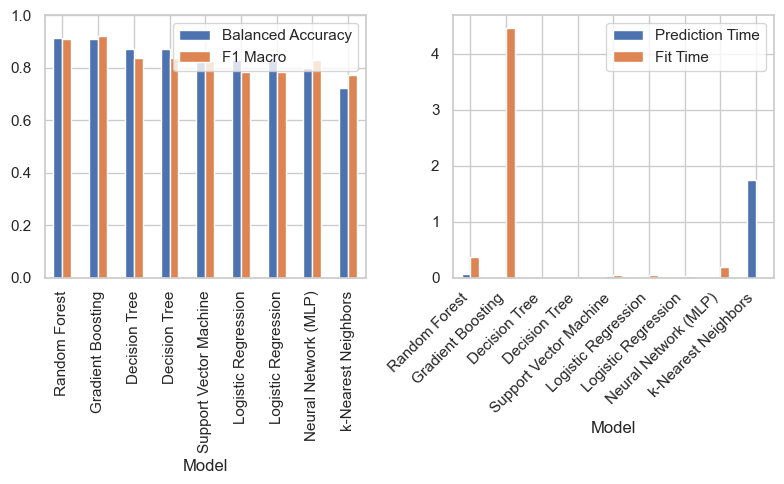

In [40]:
# Visual comparison
fig, ax = plt.subplots(1,2, figsize=(8, 5))
results_df.plot(x='Model', y=['Balanced Accuracy', 'F1 Macro'], kind='bar', ax=ax[0])
results_df.plot(x='Model', y=['Prediction Time', 'Fit Time'], kind='bar', ax=ax[1])
ax[0].set_ylim(0, 1)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()